In [6]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

sns.set_theme(style="darkgrid")

import utils.utils as utils
import utils.utils_plots as utils_plots
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
from utils.utils_models import LightGBMForecastingModel
import copied_feature_engineering as copied_functions

In [7]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

In [8]:
# Formatting columns
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], format='%Y-%m-%d', errors='coerce')
df_kaggle['sales_units'] = pd.to_numeric(df_kaggle['sales_units'], errors='coerce')
df_kaggle['inventory_units'] = pd.to_numeric(df_kaggle['inventory_units'], errors='coerce')

df_kaggle['sku'] = df_kaggle['reporterhq_id'].astype(str) + "_" + df_kaggle['product_number'].astype(str)

categorical_columns = ['id', 'product_number', 'reporterhq_id', 'prod_category', 'display_size', 'segment', 'sku']
for col in categorical_columns:
    df_kaggle[col] = df_kaggle[col].astype('category')
    df_kaggle[col] = df_kaggle[col].cat.remove_unused_categories()

# Drop columns
df_kaggle.drop(columns=['specs'], inplace=True)

In [12]:
utils_preprocessing.fill_in_missing_dates(df_kaggle).shape

/Users/matteogiaretti/Python/hp_use_case/utils/utils_preprocessing.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(["min", "max"]).reset_index()


(27692, 11)

In [13]:
# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
# df_kaggle = utils.fill_in_missing_dates(df_kaggle)

# # Interpolation and fill-in function
# def interpolate_sku(group):
#     group = group.sort_values(by='date')
#     group = group.set_index('date')  
#     group['sales_units'] = group['sales_units'].interpolate(method='time')
#     group['inventory_units'] = group['inventory_units'].interpolate(method='time')
#     return group.reset_index()

# df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)
df_kaggle = df_kaggle.dropna(subset=['inventory_units'])

In [14]:
# Generate features
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='inventory_units', window_sizes=[4, 8])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

In [6]:
df_kaggle = utils_features.create_periods_feature(df_kaggle, group_columns = ['reporterhq_id', 'product_number'], date_column = 'date', target_col='inventory_units')
df_kaggle = copied_functions.create_date_features(df=df_kaggle, date_col='date', freq='W')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_copy.groupby(group_columns)["signal_above_zero"].cumsum() > 0
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_copy["feature_periods"] = df_copy.groupby(group_columns).cumcount() + 1


In [7]:
lgb_params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': np.float64(0.9914924607394691),
    'importance_type': 'split',
    'learning_rate': np.float64(0.027590738215604697),
    'max_depth': np.int64(10),
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 500,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': np.float64(0.6006545748134953),
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

## Model evaluation

In [12]:
# tss = TimeSeriesSplit(4, test_size=13)
tss = TimeSeriesSplit(n_splits=4, test_size=10)

In [13]:
df_final = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date').sort_index()
unique_dates = pd.Series(df_final.index.unique())

In [14]:
splits = []
for train_idx, test_idx in tss.split(unique_dates):
    # Get the train/test dates
    train_dates = unique_dates.iloc[train_idx]
    test_dates = unique_dates.iloc[test_idx]
    
    # Filter the original DataFrame for these dates
    train_data = df_final[df_final.index.isin(train_dates)]
    test_data = df_final[df_final.index.isin(test_dates)]
    
    splits.append((train_data, test_data))

# Display the splits
for split_idx, (train, test) in enumerate(splits):
    print(f"Split {split_idx + 1}:")
    # print("Train Dates:", train["timestamp"].unique())
    print("Test Dates:", test.index.unique())
    print()

Split 1:
Test Dates: DatetimeIndex(['2022-08-06', '2022-08-13', '2022-08-20', '2022-08-27',
               '2022-09-03', '2022-09-10', '2022-09-17', '2022-09-24',
               '2022-10-01', '2022-10-08'],
              dtype='datetime64[ns]', name='date', freq=None)

Split 2:
Test Dates: DatetimeIndex(['2022-10-15', '2022-10-22', '2022-10-29', '2022-11-05',
               '2022-11-12', '2022-11-19', '2022-11-26', '2022-12-03',
               '2022-12-10', '2022-12-17'],
              dtype='datetime64[ns]', name='date', freq=None)

Split 3:
Test Dates: DatetimeIndex(['2022-12-24', '2022-12-31', '2023-01-07', '2023-01-14',
               '2023-01-21', '2023-01-28', '2023-02-04', '2023-02-11',
               '2023-02-18', '2023-02-25'],
              dtype='datetime64[ns]', name='date', freq=None)

Split 4:
Test Dates: DatetimeIndex(['2023-03-04', '2023-03-11', '2023-03-18', '2023-03-25',
               '2023-04-01', '2023-04-08', '2023-04-15', '2023-04-22',
               '2023-04-29'

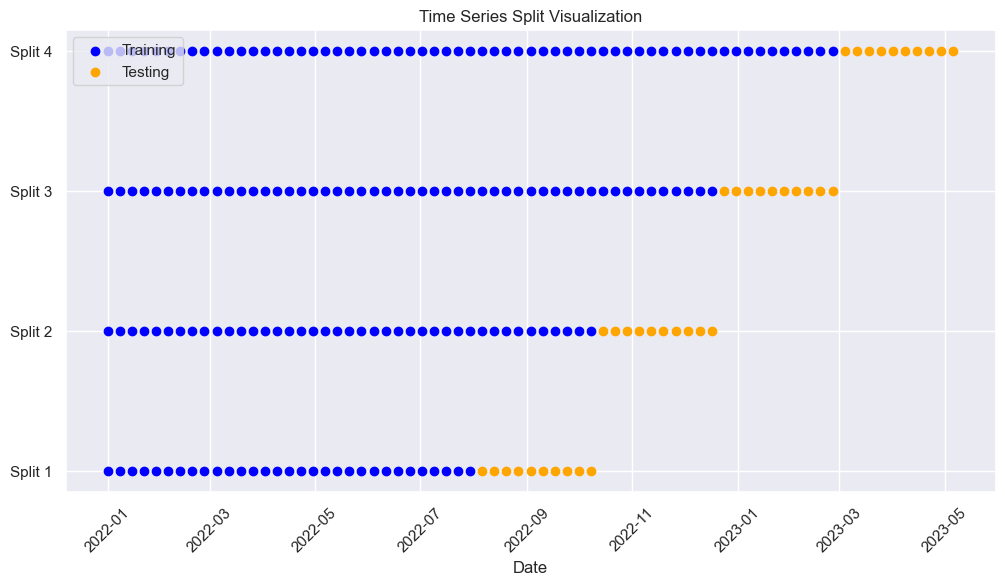

<Figure size 1400x200 with 0 Axes>

In [15]:
# Call the visualization function
df = df_final.copy().loc["2022-01":]
utils_plots.plot_time_series_split_with_dates(tss, pd.Series(range(len(df.index.unique())), index=df.index.unique(), name="original_dates"))

In [46]:
fc_model = LightGBMForecastingModel(hyperparameters=lgb_params)
average_rmse = fc_model.cross_validate(df_final, n_splits=4)

Model evaluation completed. RMSE: 57.295
Model evaluation completed. RMSE: 61.79
Model evaluation completed. RMSE: 55.299
Model evaluation completed. RMSE: 54.326
Average RMSE from cross-validation: 57.1775


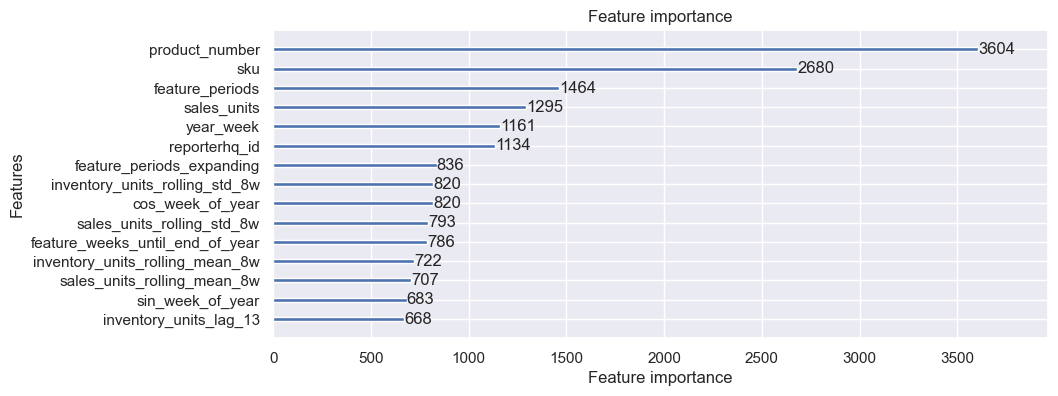

In [47]:
lgb.plot_importance(fc_model.model, importance_type='split', max_num_features=15, figsize=(10, 4))
plt.show()

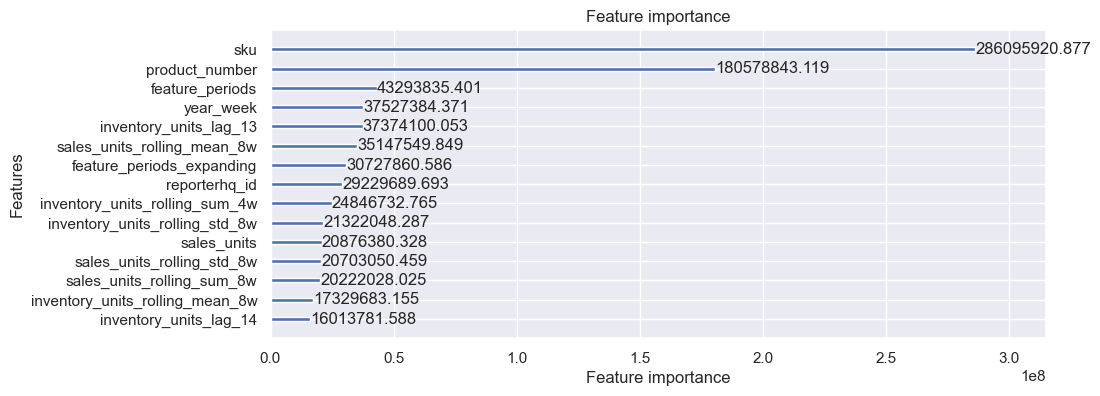

In [48]:
# Plot the feature importance based on "gain" (how much each feature improves the model)
lgb.plot_importance(fc_model.model, importance_type='gain', max_num_features=15, figsize=(10, 4))
plt.show()

In [49]:
df_final = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date').sort_index()
unique_dates = pd.Series(df_final.index.unique())

In [50]:
df_final.columns

Index(['id', 'year_week', 'product_number', 'reporterhq_id', 'prod_category',
       'display_size', 'segment', 'sales_units', 'y', 'sku', 'day_of_month',
       'week_of_month', 'week_of_year', 'month_of_year', 'year',
       'sin_day_of_month', 'cos_day_of_month', 'sin_week_of_year',
       'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year',
       'inventory_units_lag_13', 'inventory_units_lag_14',
       'inventory_units_lag_15', 'sales_units_lag_13', 'sales_units_lag_14',
       'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
       'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
       'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
       'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
       'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',
       'sales_units_rolling_mean_8w', 'sales_units_rolling_std_8w',
       'sales_units_rolling_sum_8w', 'feature_periods',
       'feature_periods_expand

In [51]:
cols_dict = {
    'simple_1': ['sku', 'y', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year'],
    'simple_3': ['sku', 'product_number', 'reporterhq_id', 'y', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year'],
    'simple_4': ['sku', 'y', 'year_week', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year'],
    'simple_5': ['sku', 'y', 'year_week', 'day_of_month', 'week_of_month', 'month_of_year', 'inventory_units_lag_13'],
    'simple_6': ['sku', 'y', 'year_week', 'day_of_month', 'week_of_month', 'month_of_year', 'inventory_units_lag_13', 'sin_day_of_month', 
                 'cos_day_of_month', 'sin_week_of_year', 'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year'],
    'simple_7': ['product_number', 'reporterhq_id', 'y', 'year_week', 'day_of_month', 'week_of_month', 'month_of_year', 'inventory_units_lag_13', 'sin_day_of_month', 
                 'cos_day_of_month', 'sin_week_of_year', 'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year'],
    'simple_8': ['sku', 'y', 'year_week', 'day_of_month', 'week_of_month', 'month_of_year', 'sin_day_of_month', 
                 'cos_day_of_month', 'sin_week_of_year', 'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year', 'inventory_units_lag_13', 'inventory_units_lag_14',
                'inventory_units_lag_15', 'sales_units_lag_13', 'sales_units_lag_14',
                'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
                'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
                'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
                'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
                'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',
                'sales_units_rolling_mean_8w', 'sales_units_rolling_std_8w',
                'sales_units_rolling_sum_8w', 'feature_periods',
                'feature_periods_expanding', 'feature_periods_sqrt',
                'feature_weeks_until_next_end_of_quarter',
                'feature_weeks_until_end_of_year',
                'feature_months_until_next_end_of_quarter',
                'feature_months_until_end_of_year'],
    # 'simple_9': ['sku', 'product_number', 'reporterhq_id', 'y', 'year_week', 'day_of_month', 'week_of_month', 'month_of_year', 'sin_day_of_month', 
    #              'cos_day_of_month', 'sin_week_of_year', 'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year', 'inventory_units_lag_13', 'inventory_units_lag_14',
    #             'inventory_units_lag_15', 'sales_units_lag_13', 'sales_units_lag_14',
    #             'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
    #             'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
    #             'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
    #             'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
    #             'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',
    #             'sales_units_rolling_mean_8w', 'sales_units_rolling_std_8w',
    #             'sales_units_rolling_sum_8w', 'feature_periods',
    #             'feature_periods_expanding', 'feature_periods_sqrt',
    #             'feature_weeks_until_next_end_of_quarter',
    #             'feature_weeks_until_end_of_year',
    #             'feature_months_until_next_end_of_quarter',
    #             'feature_months_until_end_of_year'],
    'simple_10': ['sku', 'id', 'year_week', 'product_number', 'reporterhq_id', 'y',
       'prod_category', 'display_size', 'segment', 'sales_units',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'inventory_units_lag_13', 'inventory_units_lag_14',
                'inventory_units_lag_15', 'sales_units_lag_13', 'sales_units_lag_14',
                'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
                'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
                'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
                'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
                'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',]
}

In [20]:
for key, cols in cols_dict.items():
    print(f'Columns dictionary key: {key}')
    df_final = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date').sort_index()
    df_final = df_final[cols]
    print(f'columns: {cols}')
    unique_dates = pd.Series(df_final.index.unique())
    fc_model = LightGBMForecastingModel(hyperparameters=lgb_params)
    average_rmse = fc_model.cross_validate(df_final, n_splits=4)
    print('----------------\n')

Columns dictionary key: simple_1
columns: ['sku', 'y', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year']
Model evaluation completed. RMSE: 59.239
Model evaluation completed. RMSE: 65.32
Model evaluation completed. RMSE: 59.278
Model evaluation completed. RMSE: 59.246
Average RMSE from cross-validation: 60.7707
----------------

Columns dictionary key: simple_3
columns: ['sku', 'product_number', 'reporterhq_id', 'y', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year']
Model evaluation completed. RMSE: 58.208
Model evaluation completed. RMSE: 68.208
Model evaluation completed. RMSE: 60.939
Model evaluation completed. RMSE: 58.632
Average RMSE from cross-validation: 61.4967
----------------

Columns dictionary key: simple_4
columns: ['sku', 'y', 'year_week', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year']
Model evaluation completed. RMSE: 57.664
Model evaluation completed. RMSE: 62.244
Model evaluation completed. RMSE

In [52]:
for key, cols in cols_dict.items():
    print(f'Columns dictionary key: {key}')
    df_final = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date').sort_index()
    df_final = df_final[cols]
    print(f'columns: {cols}')
    unique_dates = pd.Series(df_final.index.unique())
    fc_model = LightGBMForecastingModel(hyperparameters=lgb_params)
    average_rmse = fc_model.cross_validate(df_final, n_splits=4)
    print('----------------\n')

Columns dictionary key: simple_1
columns: ['sku', 'y', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year']
Model evaluation completed. RMSE: 58.264
Model evaluation completed. RMSE: 64.233
Model evaluation completed. RMSE: 58.739
Model evaluation completed. RMSE: 59.698
Average RMSE from cross-validation: 60.2335
----------------

Columns dictionary key: simple_3
columns: ['sku', 'product_number', 'reporterhq_id', 'y', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year']
Model evaluation completed. RMSE: 57.99
Model evaluation completed. RMSE: 68.391
Model evaluation completed. RMSE: 60.446
Model evaluation completed. RMSE: 60.185
Average RMSE from cross-validation: 61.7530
----------------

Columns dictionary key: simple_4
columns: ['sku', 'y', 'year_week', 'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year', 'year']
Model evaluation completed. RMSE: 57.519
Model evaluation completed. RMSE: 62.542
Model evaluation completed. RMSE

In [25]:
# lgb.plot_importance(fc_model.model, importance_type='split', max_num_features=20, figsize=(10, 7))
# plt.show()

## PLots

In [21]:
df_final = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date').sort_index()
unique_dates = pd.Series(df_final.index.unique())

In [22]:
time_index = df_final.index.get_level_values(-1)
time_mask = time_index > time_index.max() - np.timedelta64(13, "W")
df_final_recent = df_final.loc[time_mask]

df_final_recent = df_final_recent[cols_dict['simple_10']] # Uncomment

X_test, y_test = df_final_recent.drop(columns=['y']), df_final_recent['y']

In [23]:
y_preds = fc_model.model.predict(X=X_test)

In [24]:
df_preds = pd.DataFrame(
    data={
        "sku": X_test["sku"],
        "y_pred": y_preds,
        #"y": y_test.values
    },
    index=X_test.index
)
df_final = df_final.merge(df_preds.reset_index(), on=['date', 'sku'], how='left')

In [31]:
num_select = 4
list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
#list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

## 1

In [26]:
fc_model.evaluate(y_test, y_preds)

Model evaluation completed. RMSE: 54.207


54.207

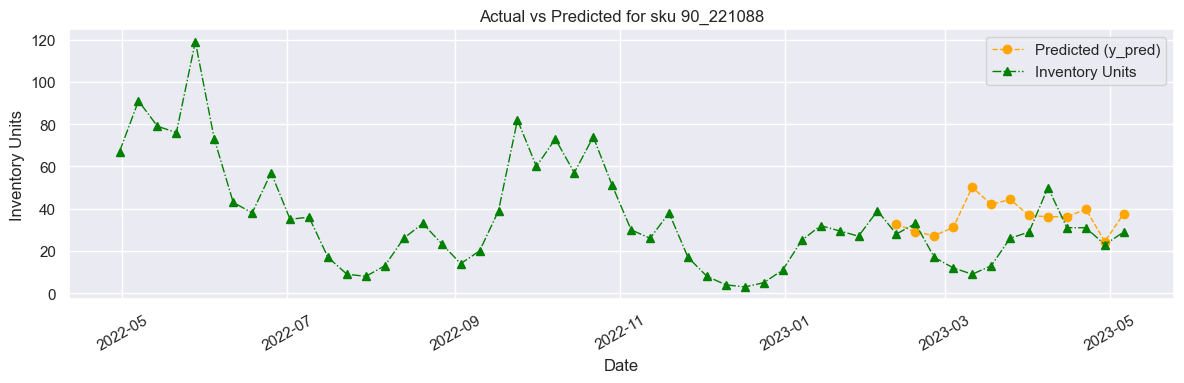

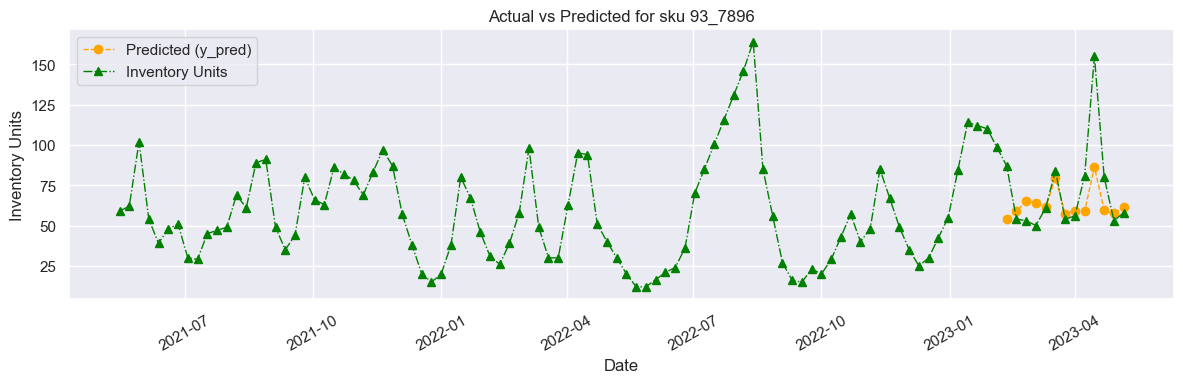

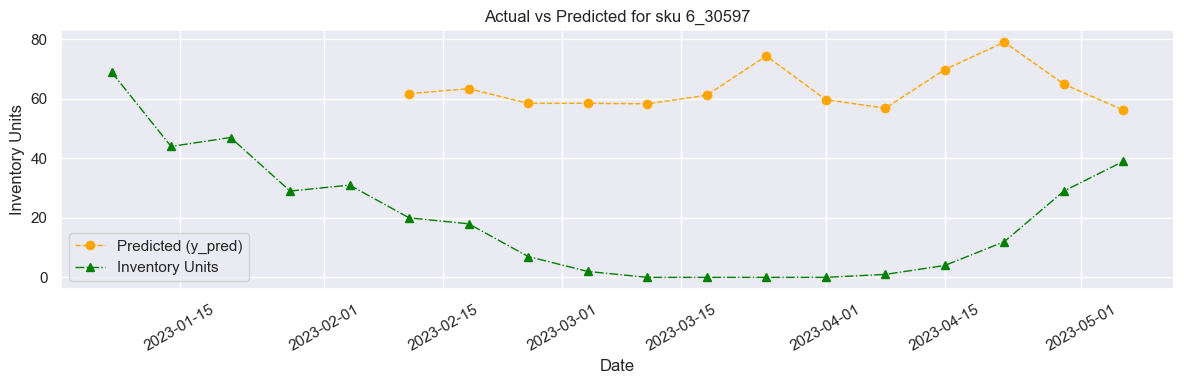

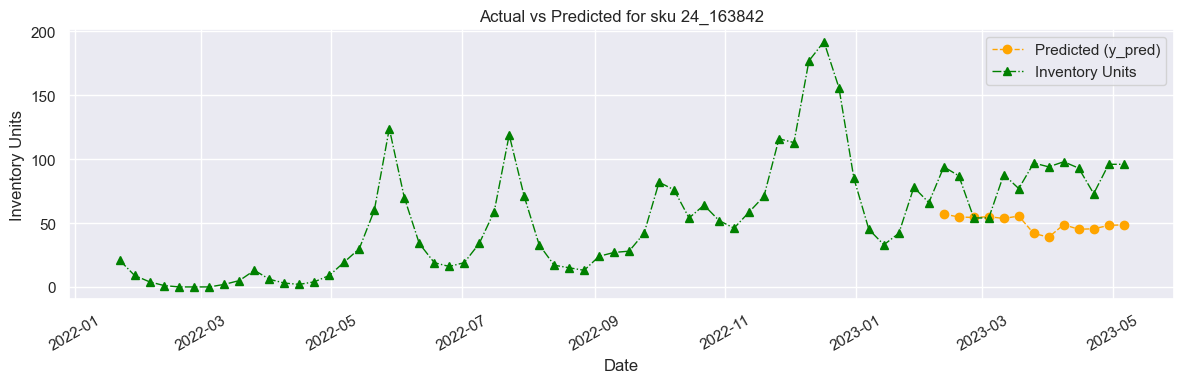

In [32]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku)

## 2

In [52]:
X_train.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'lag_13_inventory', 'lag_14_inventory', 'lag_15_inventory',
       'lag_13_sales', 'lag_14_sales', 'lag_15_sales',
       'rolling_mean_4w_inventory', 'rolling_std_4w_inventory',
       'rolling_sum_4w_inventory', 'rolling_mean_4w_sales',
       'rolling_std_4w_sales', 'rolling_sum_4w_sales'],
      dtype='object')

In [53]:
fc_model.evaluate(y_test, y_pred_train)

Model evaluation completed. RMSE: 67.028


67.028

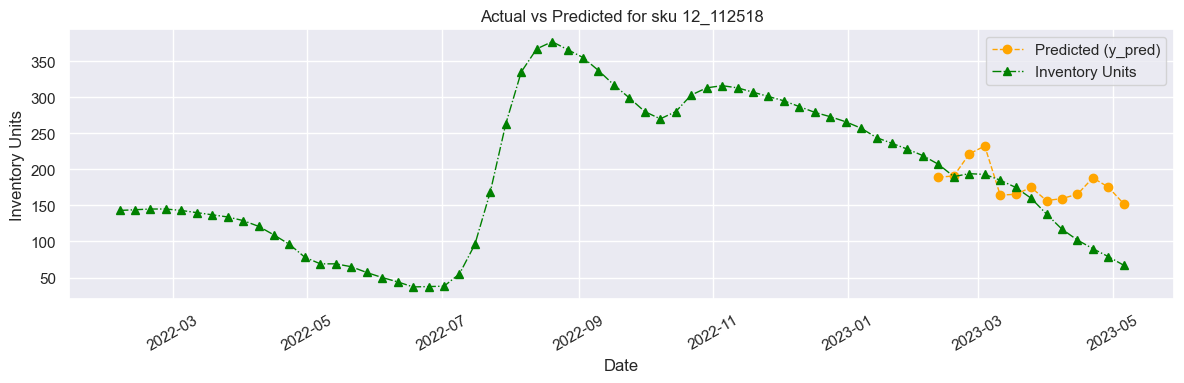

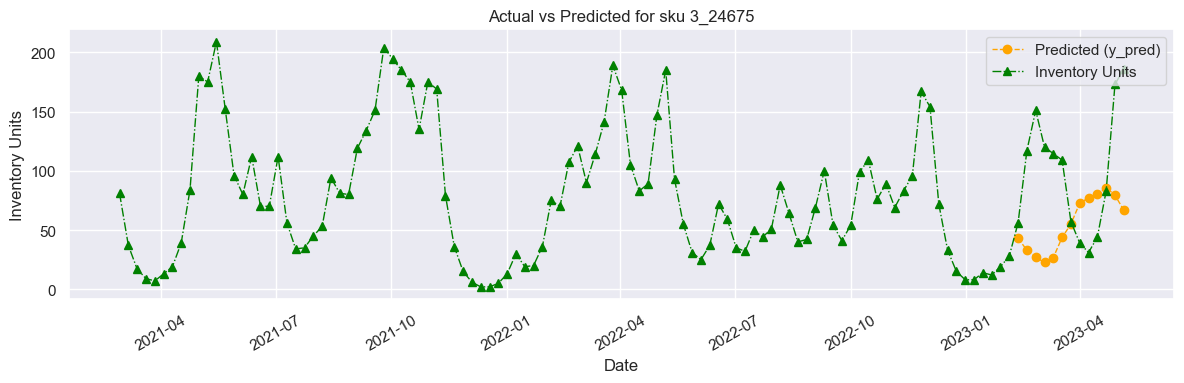

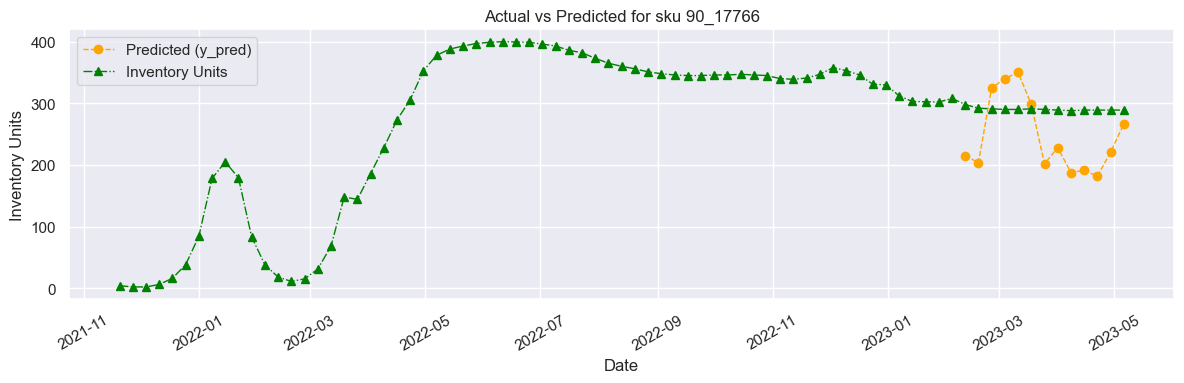

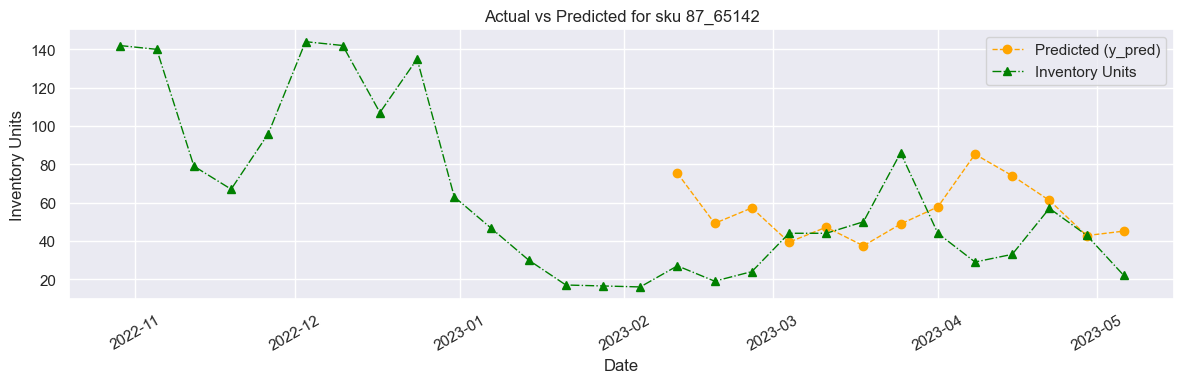

In [34]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_kaggle, sku, full_history=True)

## 3

In [13]:
X_train.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'lag_13_inventory', 'lag_14_inventory', 'lag_15_inventory',
       'lag_13_sales', 'lag_14_sales', 'lag_15_sales',
       'rolling_mean_4w_inventory', 'rolling_std_4w_inventory',
       'rolling_sum_4w_inventory', 'rolling_mean_4w_sales',
       'rolling_std_4w_sales', 'rolling_sum_4w_sales'],
      dtype='object')

In [14]:
fc_model.evaluate(y_test, y_pred_train)

Model evaluation completed. RMSE: 63.859


63.859

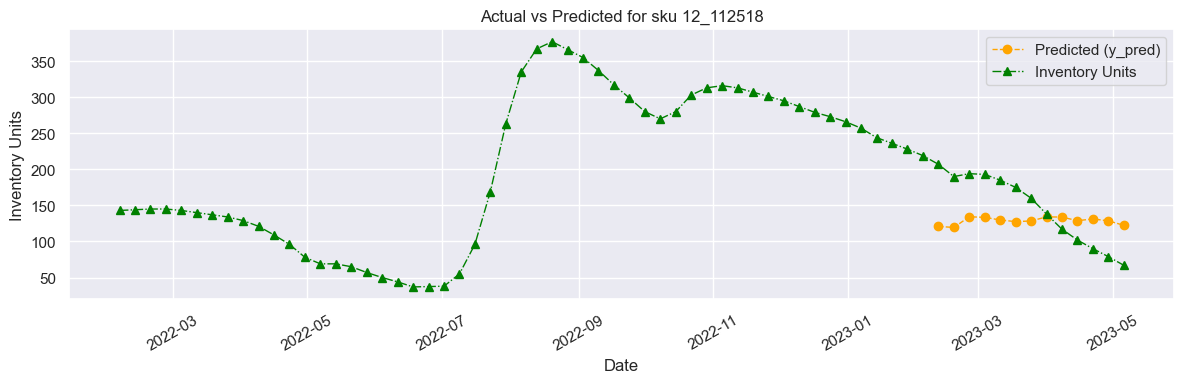

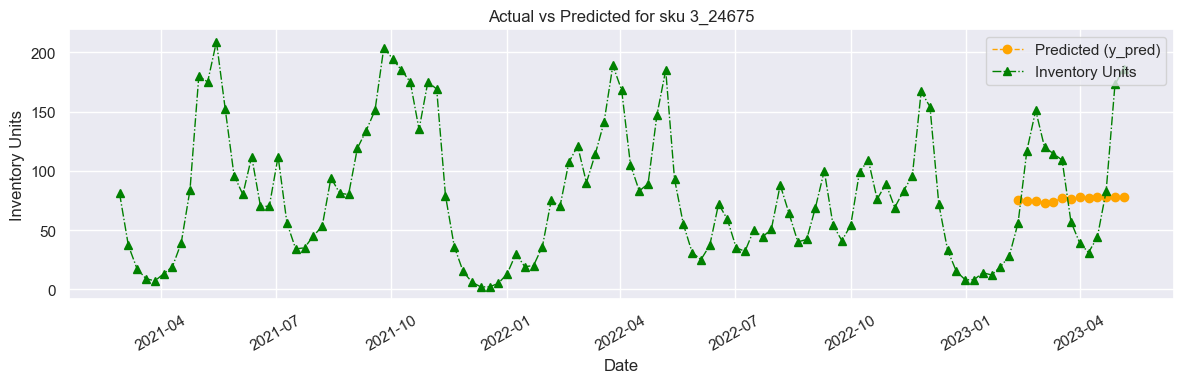

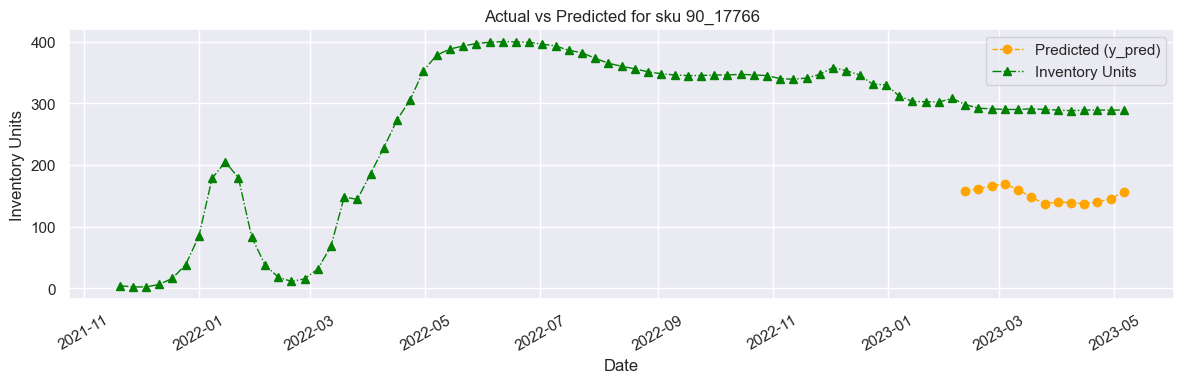

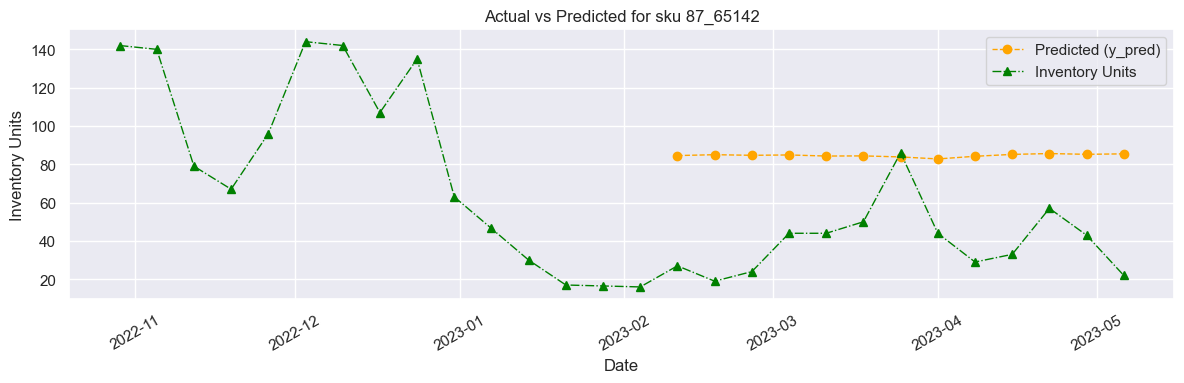

In [ ]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_kaggle, sku, full_history=True)

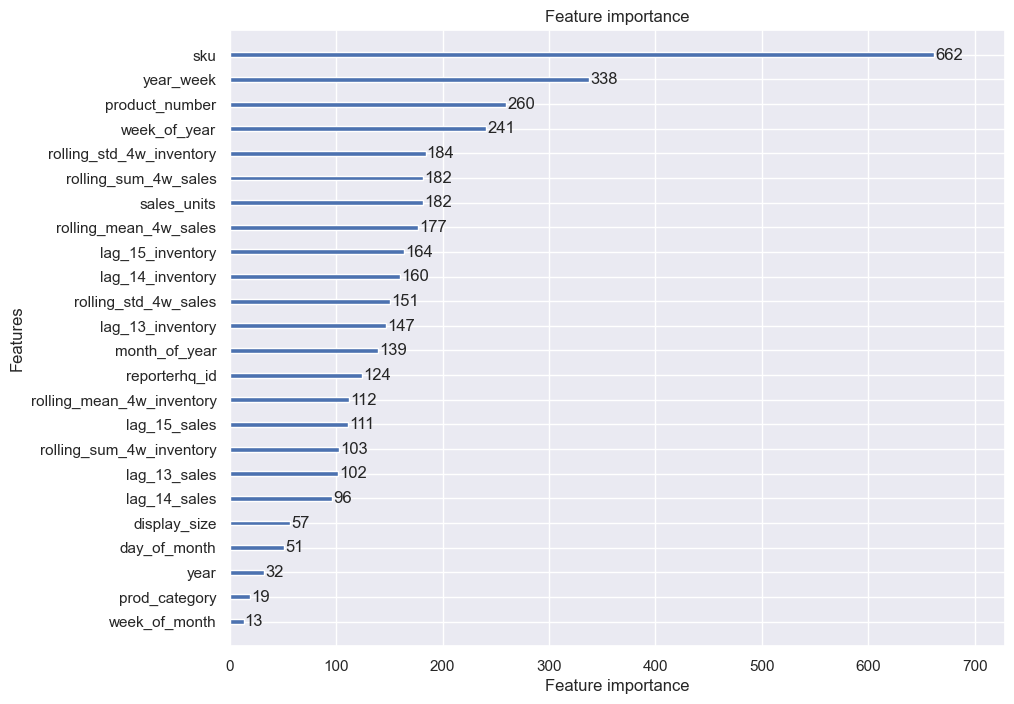

In [16]:
# Plot the feature importance based on "split" (how often a feature is used)
lgb.plot_importance(fc_model.model, importance_type='split', max_num_features=50, figsize=(10, 8))
plt.show()